In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys

sys.path.append('C:/Users/naco1/OneDrive/Documentos/GitHub/Event_Star_tracker/lib')
import utils

In [2]:
import utils
# Load data from csv star catalog 
path = '../data/vizier_I_259_tyc2_20231202_2.csv'
star_dataframe = utils.load_catalog(path)

print(star_dataframe)

      TYC1  TYC2  TYC3   VTmag  HIP    RA(ICRS)   DE(ICRS)    recno
0        2   500     1  13.158  NaN    3.100781   2.274424      230
1        5    22     1  13.380  NaN    3.460134   3.072976      706
2        5   556     1  13.204  NaN    2.958764   4.755540      798
3        6    16     1  13.925  NaN    5.024723   4.314557      877
4        6    88     1  13.096  NaN    6.822331   4.203394      885
...    ...   ...   ...     ...  ...         ...        ...      ...
9920  9527  2156     1  13.285  NaN  290.069599 -84.793113  2538602
9921  9532   411     1  13.161  NaN  314.378316 -86.610253  2539436
9922  9533   766     1  13.205  NaN  351.892780 -86.404470  2539621
9923  9533   806     1  13.148  NaN  352.993701 -87.111313  2539625
9924  9535   215     1  13.364  NaN  277.143004 -88.731150  2539783

[9925 rows x 8 columns]


In [9]:
stars_data[1,:]

array([  1.        , 358.51046514,  94.55801521])

In [3]:

stars_data = utils.random_dataset(n_stars = 4000)

print(stars_data.shape)

for i in range(5):
    print("Star ID: ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot(,y,'.')
plt.show()

(4000, 3)
Star ID:  0.0 , lat: 266.6698060010197 , len:  172.98672222223712
Star ID:  1.0 , lat: 358.51046513741153 , len:  94.55801521328026
Star ID:  2.0 , lat: 149.67118626615178 , len:  98.63901786674039
Star ID:  3.0 , lat: 163.40597008815715 , len:  37.67720211973082
Star ID:  4.0 , lat: 163.59400434521683 , len:  45.60551110174417


NameError: name 'x' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
from scipy.spatial import KDTree

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,:2])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,:2], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []
features_vec_3 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][2], "(","%0.2f" % stars_data[i][0],",","%0.2f" %stars_data[i][1],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    features_3 = []


    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        x_distance = stars_data[neighbor_index][0] - stars_data[i][0]
        y_distance = stars_data[neighbor_index][1] - stars_data[i][1]
        print("Neighbor ID:", stars_data[neighbor_index][2], "(","%0.2f" %stars_data[neighbor_index][0],",","%0.2f" %stars_data[neighbor_index][1],")", ", x-distance:", x_distance, ", y-distance:", y_distance)

        #  Define the features vector that is going to be used in the SOM:
        # TODO: Try diferent combinations of features to set the most efective one

        # features = [ x1-x2, y1-y2, x1-x3, y1-y3, ..., x1-x_n, y1-y_n]
        features_1.append(x_distance)
        features_1.append(y_distance)

        # fetaures = [ r1 * r2, r1*r3, r1*r_n]
        # features_2.append(stars_data[neighbor_index][0] * stars_data[i][0]
        #                 + stars_data[neighbor_index][1] * stars_data[i][1]) 

        # Inter neighbor features
        # features = [ x2-x3, y2-y3, x2-x4, y2-y4, ..., x_m-x_n, y_m-y_n]
        for k in range(1 +j-1,n_of_neighbor+1):
            features_2.append((stars_data[indices[i][k]][0] - stars_data[indices[i][j-1]][0])
                            *(stars_data[indices[i][k]][1] - stars_data[indices[i][j-1]][1])
                            )
        

    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)


    print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )

Star ID: 0.0 ( 127.81 , 76.38 )
Neighbor ID: 999.0 ( 129.93 , 74.95 ) , x-distance: 2.1201981526732965 , y-distance: -1.4363985788320406
Neighbor ID: 2558.0 ( 128.64 , 79.50 ) , x-distance: 0.8273148150225751 , y-distance: 3.120140064167501
Neighbor ID: 3874.0 ( 129.24 , 73.41 ) , x-distance: 1.4224278738767708 , y-distance: -2.969847915150382
Neighbor ID: 1992.0 ( 124.47 , 77.93 ) , x-distance: -3.3402255963851957 , y-distance: 1.5437638151797444
Number of features:  8 , 10
Star ID: 1.0 ( 180.58 , 103.06 )
Neighbor ID: 1085.0 ( 180.34 , 103.05 ) , x-distance: -0.24458513018521444 , y-distance: -0.017374954918039975
Neighbor ID: 1511.0 ( 182.76 , 104.22 ) , x-distance: 2.1811000042573028 , y-distance: 1.1524601554174865
Neighbor ID: 936.0 ( 176.20 , 103.89 ) , x-distance: -4.379501899829648 , y-distance: 0.8298906262364341
Neighbor ID: 2913.0 ( 178.12 , 107.18 ) , x-distance: -2.4589988491397037 , y-distance: 4.118350929306374
Number of features:  8 , 10
Star ID: 2.0 ( 66.09 , 161.81 )

, y-distance: 1.7495206199655229
Neighbor ID: 1619.0 ( 27.90 , 72.12 ) , x-distance: 0.5195542902472639 , y-distance: -1.9140214888108318
Neighbor ID: 3971.0 ( 29.97 , 76.32 ) , x-distance: 2.5956319627617717 , y-distance: 2.281624966636471
Number of features:  8 , 10
Star ID: 436.0 ( 325.61 , 87.83 )
Neighbor ID: 2468.0 ( 325.34 , 87.99 ) , x-distance: -0.2690799219823248 , y-distance: 0.15388541364838204
Neighbor ID: 2217.0 ( 325.52 , 88.43 ) , x-distance: -0.09049174937268845 , y-distance: 0.590845010276297
Neighbor ID: 505.0 ( 324.87 , 85.90 ) , x-distance: -0.7394277571798398 , y-distance: -1.9357172895237227
Neighbor ID: 223.0 ( 323.39 , 92.25 ) , x-distance: -2.216595614516166 , y-distance: 4.41067762861114
Number of features:  8 , 10
Star ID: 437.0 ( 129.43 , 167.00 )
Neighbor ID: 1608.0 ( 130.92 , 168.96 ) , x-distance: 1.4925122244408726 , y-distance: 1.9658896497546436
Neighbor ID: 2279.0 ( 129.44 , 169.57 ) , x-distance: 0.013736037360843056 , y-distance: 2.572520178448201


In [ ]:

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min(axis=0)) / (star_features.max(axis=0) - star_features.min(axis=0))
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 
mesh_size = 44

# Initialize the SOM
som1 = MiniSom(
    x = mesh_size,
    y = mesh_size,
    input_len = features_1_n.shape[1],
    sigma=2.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)
print(f"SOM size = {mesh_size} x {mesh_size}")
som2 = MiniSom(
    x = mesh_size,
    y = mesh_size,
    input_len = features_2_n.shape[1],
    sigma=2.0,
    learning_rate=0.7,
    neighborhood_function='gaussian',
)
print(f"SOM size = {mesh_size} x {mesh_size}")

# Train the SOM
som1.train_random(data=features_1_n, num_iteration=500000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=500000, verbose= True)


SOM size = 44 x 44
SOM size = 44 x 44
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 0.14266470867159248
 [ 500000 / 500000 ] 100% - 0:00:00 left 
 quantization error: 0.07079018900029321


In [ ]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_1

Number of neurons with data: 1765 ; Total neurons: 1936
Number of neurons with data: 1745 ; Total neurons: 1936


{(0, 2): [0, 539, 1593, 2172, 3812],
 (32, 19): [1, 108, 1324, 1582, 3208],
 (25, 1): [2, 401],
 (21, 15): [3, 57, 3537],
 (30, 12): [4, 1188, 2258, 2427],
 (28, 2): [5, 3988],
 (41, 35): [6, 783, 3073],
 (38, 31): [7, 244, 2230, 3320],
 (30, 3): [8, 3230],
 (34, 17): [9, 2196],
 (39, 36): [10, 2228, 2921],
 (10, 27): [11, 2168, 2939],
 (10, 30): [12, 2214, 2990],
 (5, 37): [13, 1746, 2451],
 (28, 36): [14, 738],
 (23, 21): [15, 2270, 3080, 3164, 3489],
 (26, 41): [16, 684],
 (33, 43): [17, 3298],
 (22, 24): [18, 814, 1243],
 (15, 8): [19, 724, 1608, 2241],
 (41, 14): [20, 141],
 (33, 41): [21, 2094],
 (0, 25): [22],
 (30, 20): [23, 1840, 2568],
 (41, 43): [24, 562, 1212, 1391],
 (19, 33): [25, 2912],
 (5, 19): [26, 768],
 (41, 11): [27, 28, 559, 1539, 3953],
 (37, 42): [29],
 (21, 39): [30, 532, 1782],
 (0, 5): [31, 253, 824, 3060],
 (30, 9): [32, 2056, 2101],
 (26, 38): [33, 1265, 3821],
 (2, 21): [34, 1819, 2126],
 (41, 4): [35, 1150, 2532],
 (13, 31): [36, 3238, 3751],
 (12, 17): [

SOM1: Predicted Stars ID: [1655, 3284, 3425]
SOM2: Predicted Stars ID: [1306, 1461, 3284, 3498]
Final guess: 3284, actual star ID: 3284


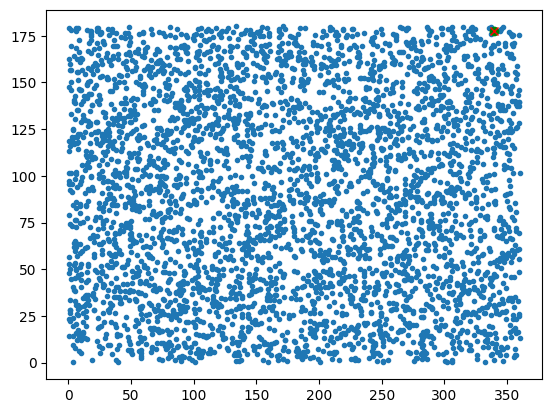

In [ ]:
# Define a function to predict the star ID for a given feature vector
def predict_star_id(features, features_array, dictionary, som):
    normalized_feature = (features - features_array.min(axis=0)) / (features_array.max(axis=0) - features_array.min(axis=0))
    winner = som.winner(normalized_feature)
    if winner in dictionary:
        return dictionary[winner]
    else:
        return [0] #The neuron has no star ID return [0], the ID start at 1 
    
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(x,y,'.')
plt.plot(stars_data[random_id][0],stars_data[random_id][1],'og')
plt.plot(stars_data[star_guess][0],stars_data[star_guess][1],'xr')
plt.show()


In [ ]:

cont = np.zeros(3) # [Correct match, miss match, multiple match]

for i in range(features_vec_1.shape[0]):

    # Itroduce noise in the features vector to check the response of the SOM
    scale = 0.01 # % respect max value 
    sample_feature_1= features_vec_1[i] - np.random.normal(loc=0, scale=1, size=features_vec_1.shape[1])*np.max(features_vec_1)*scale
    sample_feature_2= features_vec_2[i] - np.random.normal(loc=0, scale=1, size=features_vec_2.shape[1])*np.max(features_vec_2)*scale


    predicted_star_ids_1 = predict_star_id(sample_feature_1,np.array(features_vec_1),star_dict_1,som1)
    predicted_star_ids_2 = predict_star_id(sample_feature_2,np.array(features_vec_2),star_dict_2,som2)

    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))
    if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) == 1:
        cont[0] += star_guess[0] == i
    else:
        # print("Error: ", list(set(predicted_star_ids_1).intersection(predicted_star_ids_2)), "!=", i)
        cont[1] += len(star_guess) == 0
        cont[2] += len(star_guess) > 1

print("total succes =",  cont / features_vec_1.shape[0])

total succes = [0.63925 0.2565  0.088  ]
